In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_excel('../data/premiums_young.xlsx')
df.head(3)

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857


In [3]:
df.shape

(20096, 13)

In [4]:
df.columns = df.columns.str.replace(' ','_').str.lower()
df.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712


### Handle Null Values

In [5]:
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           2
employment_status        1
income_level             4
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [6]:
df.dropna(inplace=True)

In [7]:
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [8]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

In [9]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.718019,22.510851,8142.096267
std,2.294052,0.940713,23.420493,2749.906347
min,18.000000,-3.000000,1.000000,3501.000000
25%,19.000000,0.000000,6.000000,6022.250000
50%,22.000000,0.000000,16.000000,7939.000000
75%,23.000000,1.000000,31.000000,9561.000000
max,25.000000,3.000000,790.000000,18186.000000


### Treat Outliers

In [10]:
df[df.number_of_dependants < 0]['number_of_dependants'].unique()


array([-3, -1])

In [11]:
df['number_of_dependants'] = abs(df['number_of_dependants'])
df['number_of_dependants'].describe()

count    20090.000000
mean         0.722598
std          0.937200
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: number_of_dependants, dtype: float64

In [12]:
 numeric_columns = df.select_dtypes(['float64', 'int64']).columns

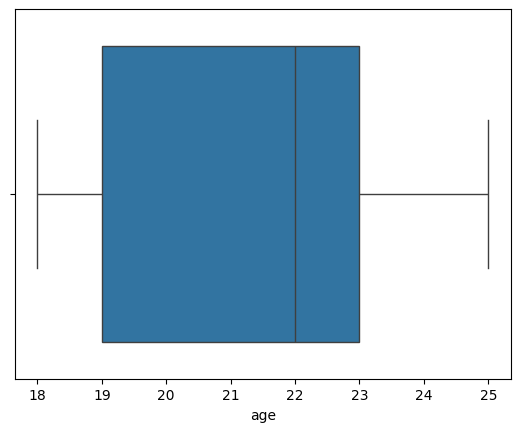

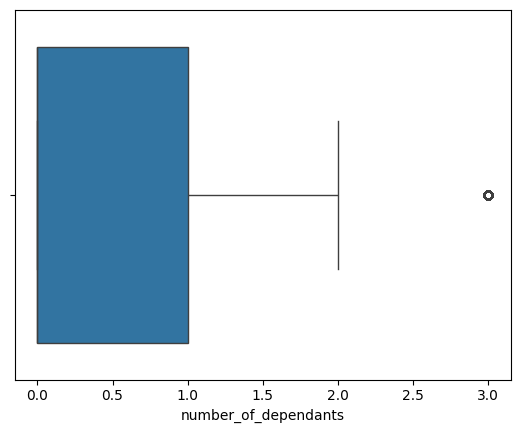

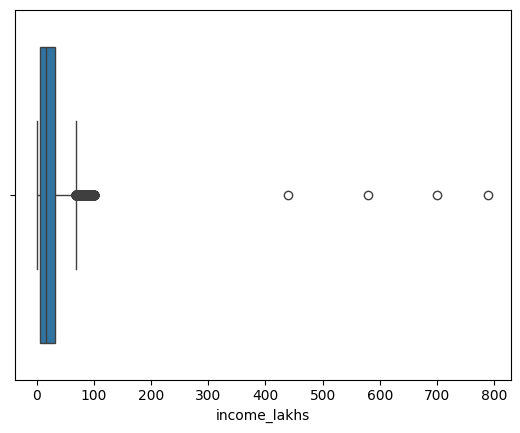

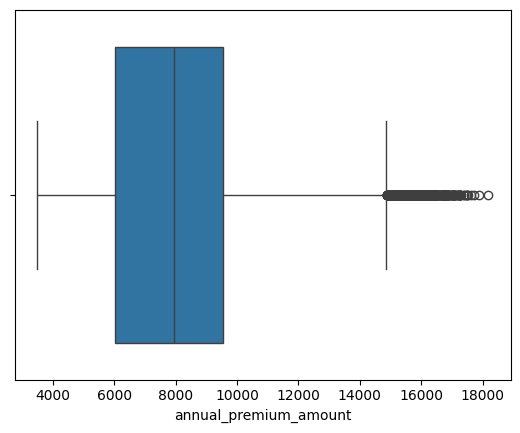

In [13]:
for col in numeric_columns:
    sns.boxplot(x=df[col])
    plt.show()

In [14]:
df1 = df[df.age<= 100].copy()
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.722598,22.510851,8142.096267
std,2.294052,0.937200,23.420493,2749.906347
min,18.000000,0.000000,1.000000,3501.000000
25%,19.000000,0.000000,6.000000,6022.250000
50%,22.000000,0.000000,16.000000,7939.000000
75%,23.000000,1.000000,31.000000,9561.000000
max,25.000000,3.000000,790.000000,18186.000000


<Axes: xlabel='income_lakhs', ylabel='Count'>

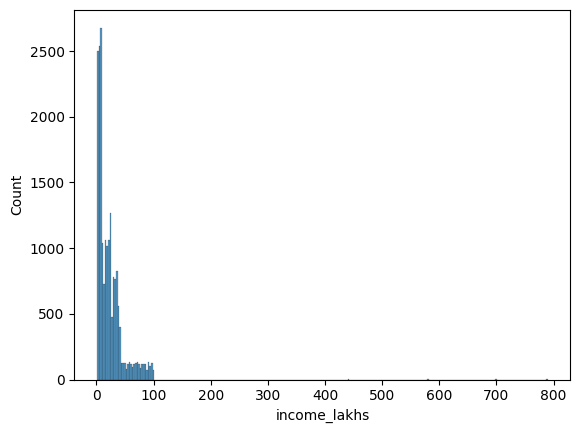

In [15]:
sns.histplot(df1.income_lakhs)

In [16]:
def get_iqr_bounds(col):
    q1, q3 = col.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr 
    return lower_bound, upper_bound

In [17]:
get_iqr_bounds(df1['income_lakhs'])

(-31.5, 68.5)

In [18]:
quantile_threshold = df1['income_lakhs'].quantile(0.999)

In [19]:
df2 = df1[df1['income_lakhs'] <= quantile_threshold].copy()
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20086.000000,20086.000000,20086.000000,20086.000000
mean,21.494474,0.722742,22.390371,8141.799263
std,2.294248,0.937238,21.732062,2749.912486
min,18.000000,0.000000,1.000000,3501.000000
25%,19.000000,0.000000,6.000000,6022.000000
50%,22.000000,0.000000,16.000000,7939.000000
75%,23.000000,1.000000,31.000000,9561.000000
max,25.000000,3.000000,100.000000,18186.000000


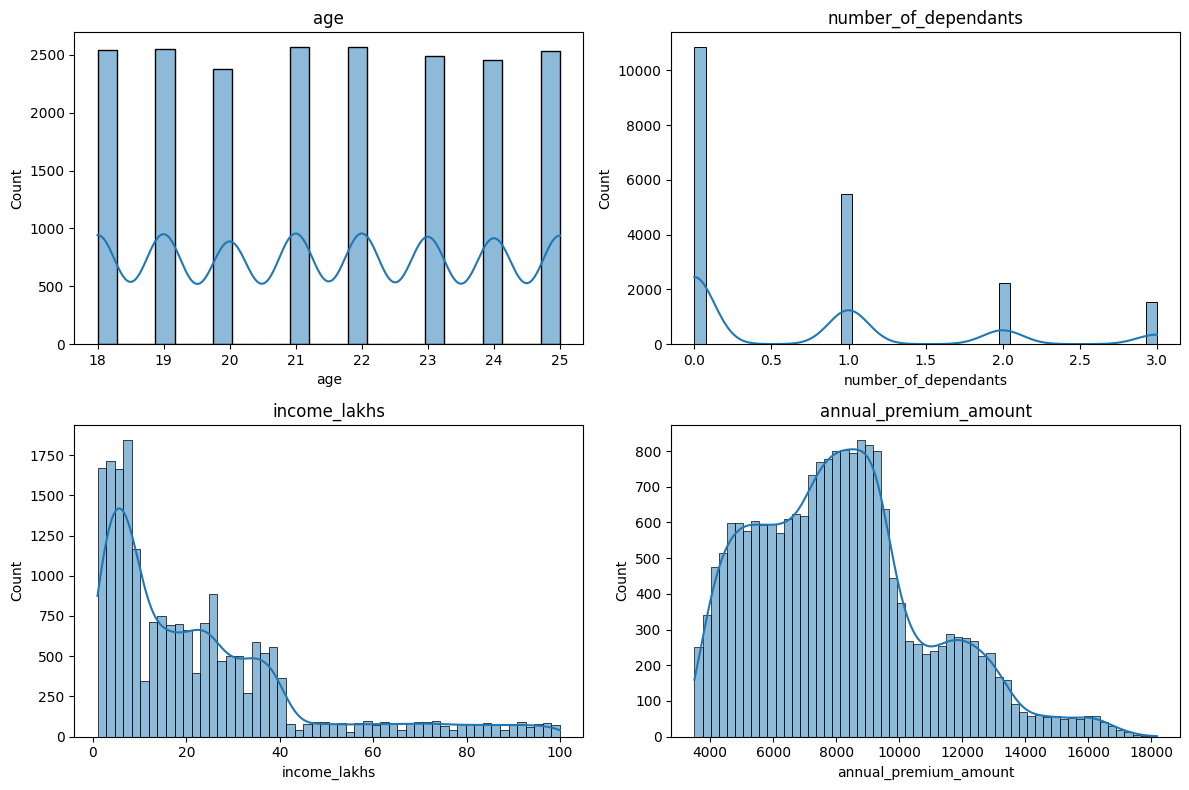

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Flatten axes array to loop over it easily
axes = axes.flatten()

# Loop through columns and plot each one
for i, col in enumerate(numeric_columns):
    sns.histplot(df2[col], kde=True, ax=axes[i])
    axes[i].set_title(col)

# Remove any empty plots if you have fewer than 4 columns
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

<Axes: xlabel='age', ylabel='annual_premium_amount'>

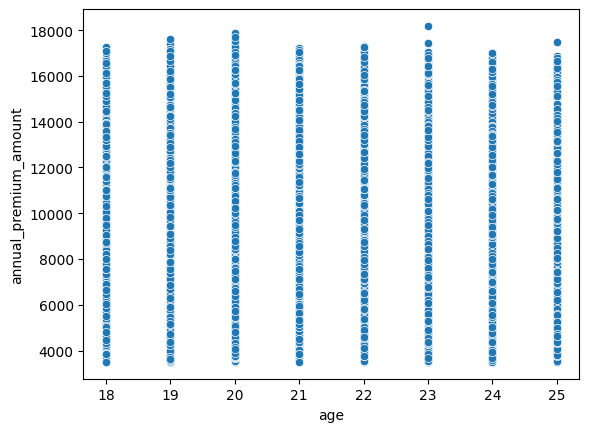

In [21]:
 sns.scatterplot(df2, x='age', y='annual_premium_amount')

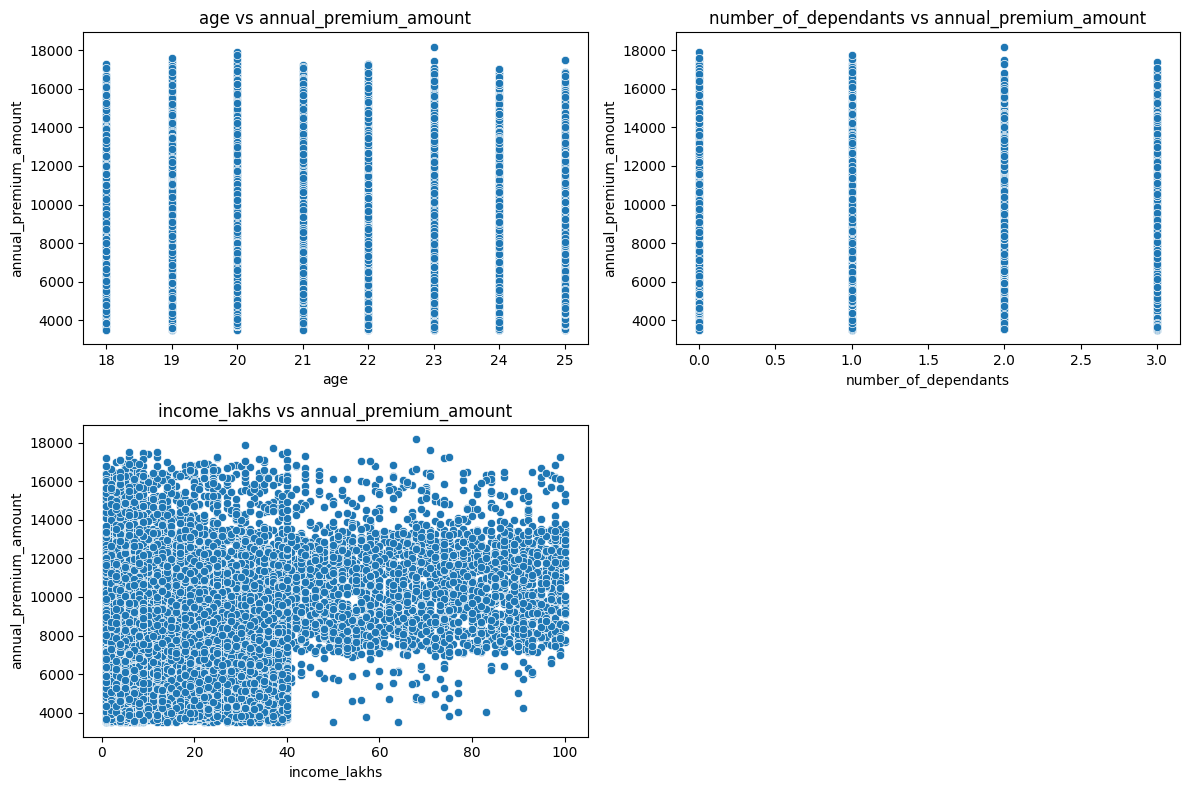

In [22]:
num_cols = ['age', 'number_of_dependants', 'income_lakhs']

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

# Plot each numeric column against annual_premium_amount
for i, col in enumerate(num_cols):
    sns.scatterplot(data=df2, x=col, y='annual_premium_amount', ax=axes[i])
    axes[i].set_title(f'{col} vs annual_premium_amount')

# Remove empty plots if there are fewer columns
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [23]:
categorical_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status', 'income_level', 'medical_history', 'insurance_plan']
categorical_cols

['gender',
 'region',
 'marital_status',
 'bmi_category',
 'smoking_status',
 'employment_status',
 'income_level',
 'medical_history',
 'insurance_plan']

In [24]:
for col in categorical_cols:
    print(col, df2[col].unique())

gender ['Male' 'Female']
region ['Northeast' 'Northwest' 'Southeast' 'Southwest']
marital_status ['Unmarried' 'Married']
bmi_category ['Overweight' 'Underweight' 'Normal' 'Obesity']
smoking_status ['Regular' 'No Smoking' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status ['Self-Employed' 'Freelancer' 'Salaried']
income_level ['> 40L' '<10L' '10L - 25L' '25L - 40L']
medical_history ['High blood pressure' 'No Disease' 'Diabetes & High blood pressure'
 'Diabetes & Heart disease' 'Diabetes' 'Diabetes & Thyroid'
 'Heart disease' 'Thyroid' 'High blood pressure & Heart disease']
insurance_plan ['Silver' 'Bronze' 'Gold']


In [25]:
df2['smoking_status'].replace({
     'Does Not Smoke': 'No Smoking',
     'Smoking=0': 'No Smoking',
     'Not Smoking': 'No Smoking'
 }, inplace=True)
df2['smoking_status'].unique()

/var/folders/4j/ccrx4x8s4m7dl9xp5_fhv6fw0000gn/T/ipykernel_73508/1482189062.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['smoking_status'].replace({


array(['Regular', 'No Smoking', 'Occasional'], dtype=object)

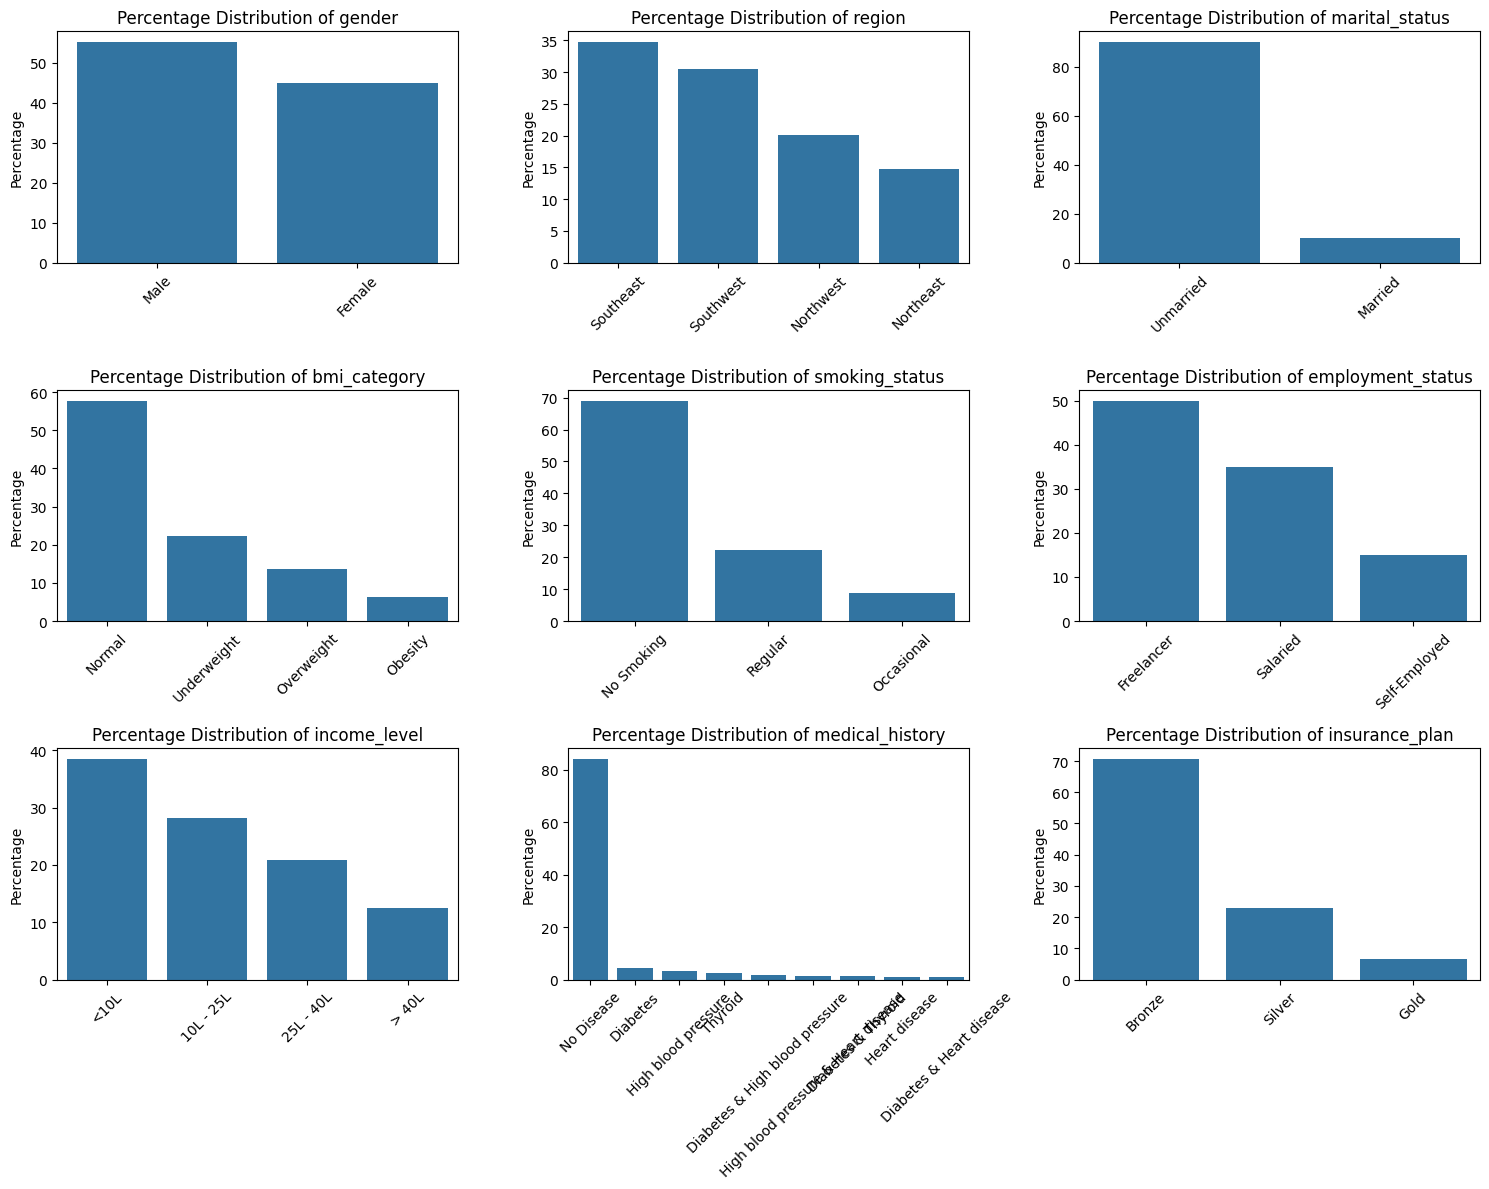

In [26]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

# Loop through each categorical column
for i, col in enumerate(categorical_cols):
    # Calculate percentage values
    percentage = (
        df2[col].value_counts(normalize=True) * 100
    ).reset_index()
    percentage.columns = [col, 'percentage']
    
    # Plot
    sns.barplot(data=percentage, x=col, y='percentage', ax=axes[i])
    axes[i].set_title(f'Percentage Distribution of {col}')
    axes[i].set_ylabel('Percentage')
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', rotation=45)

# Remove any empty subplots (in case of fewer than 9)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [27]:
crosstab = pd.crosstab(df2['income_level'], df2['insurance_plan'])

<function matplotlib.pyplot.show(close=None, block=None)>

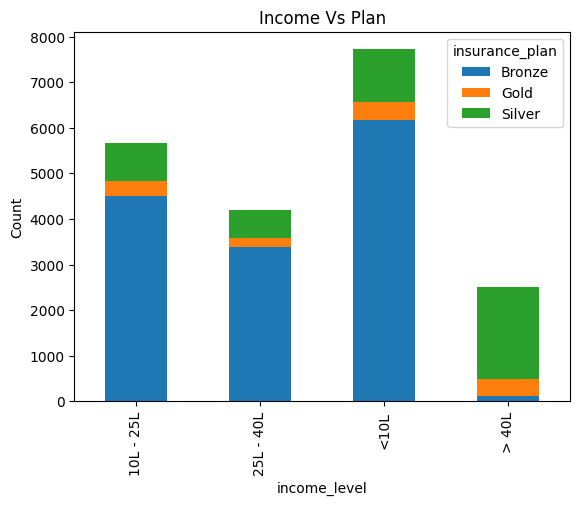

In [28]:
crosstab.plot(kind="bar", stacked=True)
plt.title('Income Vs Plan')
plt.ylabel('Count')
plt.show

### Feature Engineering

### Calculate Risk Score

In [29]:
# Define the risk scores for each condition
risk_scores = {
    "diabetes": 6,
    "heart disease": 8,
    "high blood pressure":6,
    "thyroid": 5,
    "no disease": 0,
    "none":0
}

df2[['disease1', 'disease2']] = df2['medical_history'].str.split(" & ", expand=True).apply(lambda x: x.str.lower())
df2['disease1'].fillna('none', inplace=True)
df2['disease2'].fillna('none', inplace=True)
df2['total_risk_score'] = 0

for disease in ['disease1', 'disease2']:
    df2['total_risk_score'] += df2[disease].map(risk_scores)

# Normalize the risk score to a range of 0 to 1
max_score = df2['total_risk_score'].max()
min_score = df2['total_risk_score'].min()
df2['normalized_risk_score'] = (df2['total_risk_score'] - min_score) / (max_score - min_score)
df2.head(2)

/var/folders/4j/ccrx4x8s4m7dl9xp5_fhv6fw0000gn/T/ipykernel_73508/59644619.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['disease1'].fillna('none', inplace=True)
/var/folders/4j/ccrx4x8s4m7dl9xp5_fhv6fw0000gn/T/ipykernel_73508/59644619.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beh

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,high blood pressure,none,6,0.428571
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,no disease,none,0,0.000000


### Encode Text Columns

In [30]:
df2['insurance_plan'] = df2['insurance_plan'].map({ 'Bronze': 1, 'Silver': 2, 'Gold': 3})
df2['insurance_plan'].unique()

array([2, 1, 3])

In [31]:
df2['income_level'] = df2['income_level'].map({'<10L':1, '10L - 25L': 2, '25L - 40L':3, '> 40L':4})
df2['income_level'].unique()

array([4, 1, 2, 3])

In [32]:
nominal_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status']
df3 = pd.get_dummies(df2, columns=nominal_cols, drop_first=True, dtype=int)
df3.head(3)

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,4,99,High blood pressure,2,13365,high blood pressure,none,6,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,No Disease,2,11050,no disease,none,0,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,21,0,4,97,No Disease,2,11857,no disease,none,0,0.000000,0,0,1,0,1,0,0,0,0,1,1,0


In [33]:
df4 = df3.drop(columns=['medical_history', 'disease1', 'disease2', 'total_risk_score'], axis=1)
df4.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,4,99,2,13365,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,2,11050,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,21,0,4,97,2,11857,0.000000,0,0,1,0,1,0,0,0,0,1,1,0
3,25,0,2,15,1,5684,0.000000,1,0,1,0,1,0,0,0,0,0,0,0
4,20,2,2,14,1,5712,0.000000,1,0,1,0,1,0,1,0,0,0,0,0


### Calculate VIF for Multicolinearity

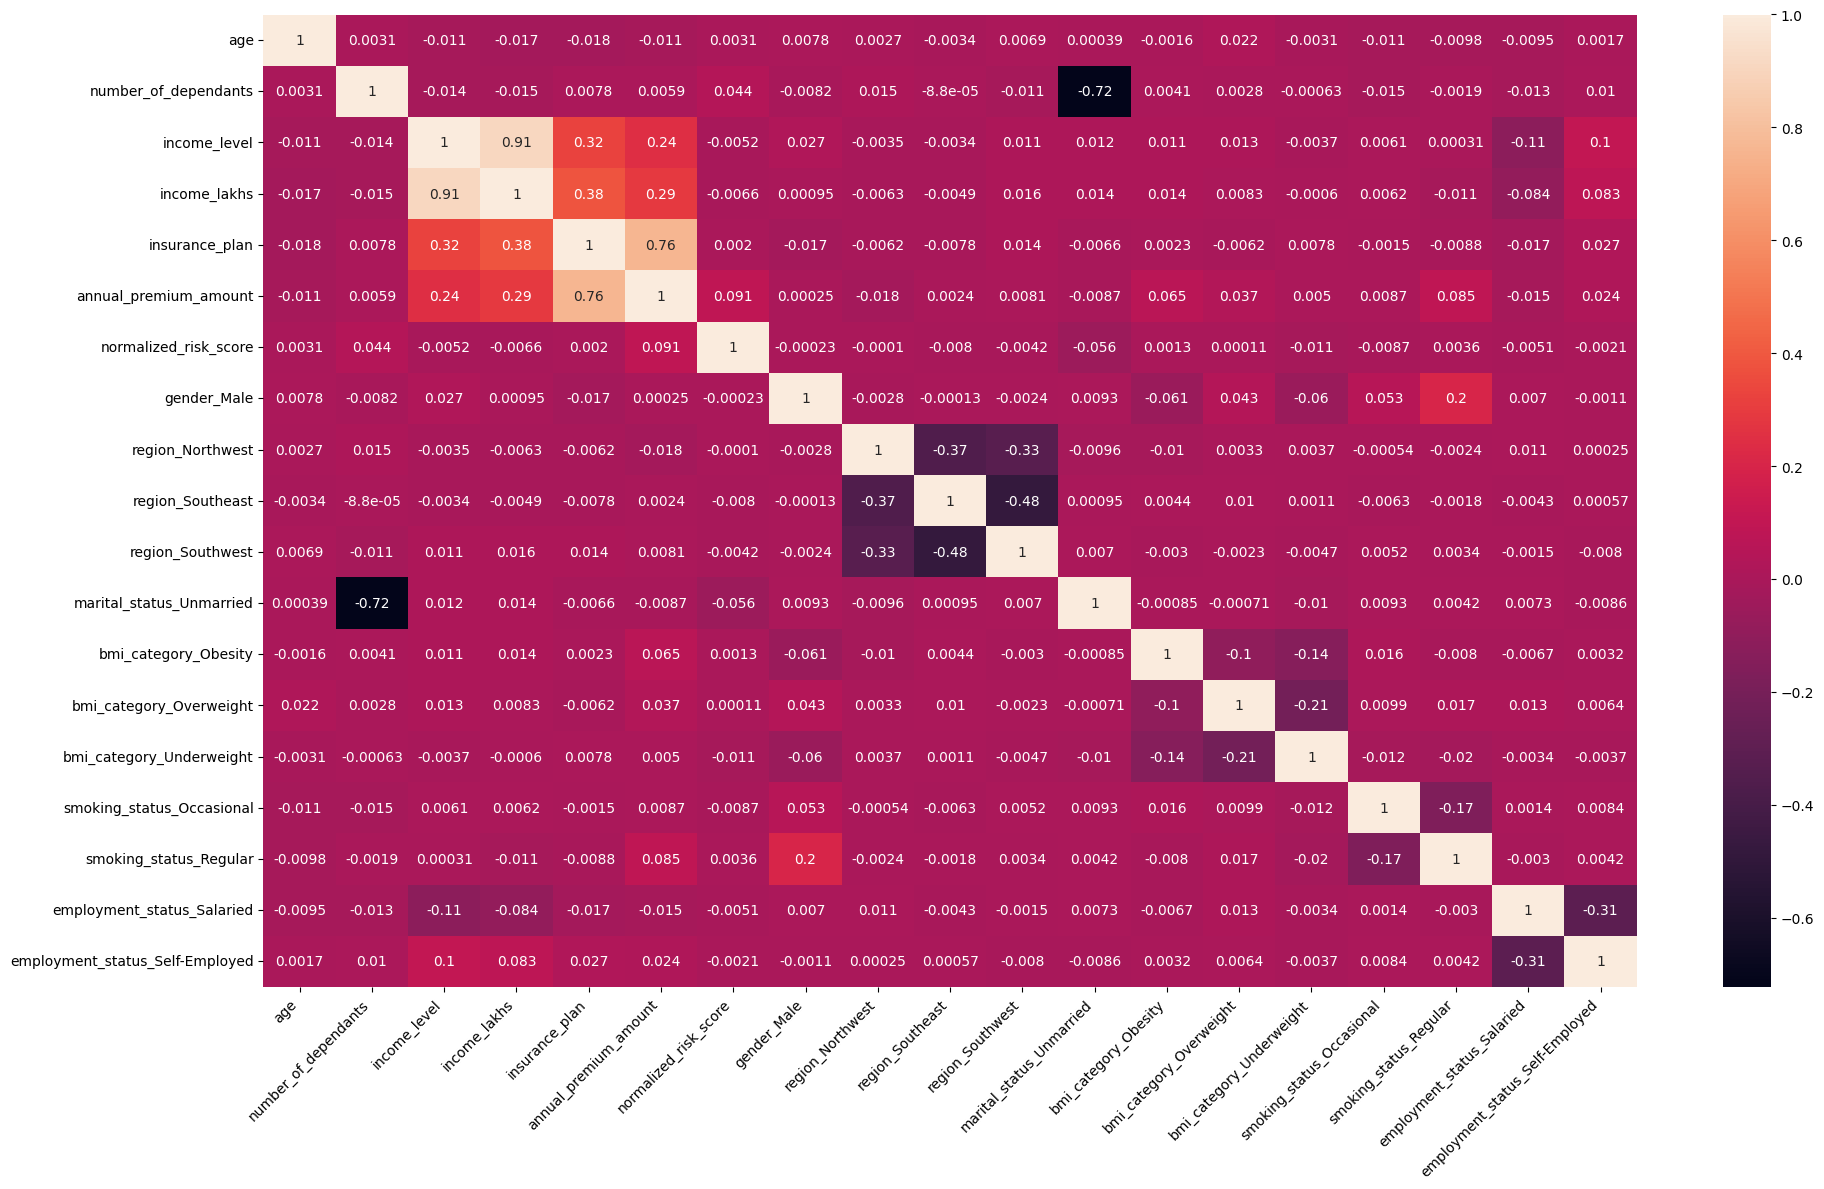

In [34]:
cm = df4.corr()

plt.figure(figsize=(20,12))
sns.heatmap(cm, annot=True)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [35]:
X = df4.drop('annual_premium_amount', axis=1)
y = df4['annual_premium_amount']

cols_to_scale = ['age', 'number_of_dependants', 'income_level', 'income_lakhs', 'insurance_plan']
scaler = MinMaxScaler()

X[cols_to_scale] =  scaler.fit_transform(X[cols_to_scale])
X.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000
mean,0.499211,0.240914,0.357994,0.216064,0.179578,0.092076,0.550383,0.201284,0.346958,0.304590,0.899881,0.063527,0.136513,0.222493,0.086379,0.223589,0.350045,0.149955
std,0.327750,0.312413,0.347481,0.219516,0.300051,0.230016,0.497467,0.400970,0.476014,0.460245,0.300167,0.243914,0.343341,0.415931,0.280929,0.416660,0.476996,0.357036
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.142857,0.000000,0.000000,0.050505,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.571429,0.000000,0.333333,0.151515,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.714286,0.333333,0.666667,0.303030,0.500000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [36]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values,i) for i in range(data.shape[1])]
    return vif_df

In [37]:
calculate_vif(X)

,Column,VIF
0,age,3.142881
1,number_of_dependants,1.860761
2,income_level,11.928707
3,income_lakhs,11.874242
4,insurance_plan,1.592892
5,normalized_risk_score,1.154223
6,gender_Male,2.310023
7,region_Northwest,2.147701
8,region_Southeast,2.970188
9,region_Southwest,2.730503


In [38]:
calculate_vif(X.drop('income_level', axis="columns"))

,Column,VIF
0,age,3.141534
1,number_of_dependants,1.858110
2,income_lakhs,2.291873
3,insurance_plan,1.587794
4,normalized_risk_score,1.154174
5,gender_Male,2.299848
6,region_Northwest,2.146767
7,region_Southeast,2.968993
8,region_Southwest,2.729813
9,marital_status_Unmarried,7.299818


In [39]:
X_reduced =  X.drop('income_level', axis="columns")
X_reduced.head()

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.000000,0.989899,0.5,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,0.571429,0.000000,0.020202,0.5,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,0.428571,0.000000,0.969697,0.5,0.000000,0,0,1,0,1,0,0,0,0,1,1,0
3,1.000000,0.000000,0.141414,0.0,0.000000,1,0,1,0,1,0,0,0,0,0,0,0
4,0.285714,0.666667,0.131313,0.0,0.000000,1,0,1,0,1,0,1,0,0,0,0,0


### Model Training

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=10)

In [41]:
# shape of the X_train, X_test, y_train, y_test features
print("x train: ",X_train.shape)
print("x test: ",X_test.shape)
print("y train: ",y_train.shape)
print("y test: ",y_test.shape)

x train:  (14060, 17)
x test:  (6026, 17)
y train:  (14060,)
y test:  (6026,)


In [42]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
train_score = model_lr.score(X_train, y_train)
test_score = model_lr.score(X_test, y_test)

train_score, test_score

(0.6020471274164894, 0.6047589163893645)

In [43]:
model_lr.intercept_

np.float64(6614.583391230755)

In [44]:
model_lr.coef_

array([ 5.51905147e+01, -1.45039643e+02, -3.60667677e+01,  7.00007042e+03,
        1.11127879e+03,  9.82564766e+00, -1.14273450e+02, -3.64663714e+01,
       -6.72232248e+01, -5.85343424e+01,  7.92952660e+02,  4.35760406e+02,
        1.69728916e+02,  2.44813937e+02,  6.19082947e+02, -1.30535485e+01,
       -4.34272200e+00])

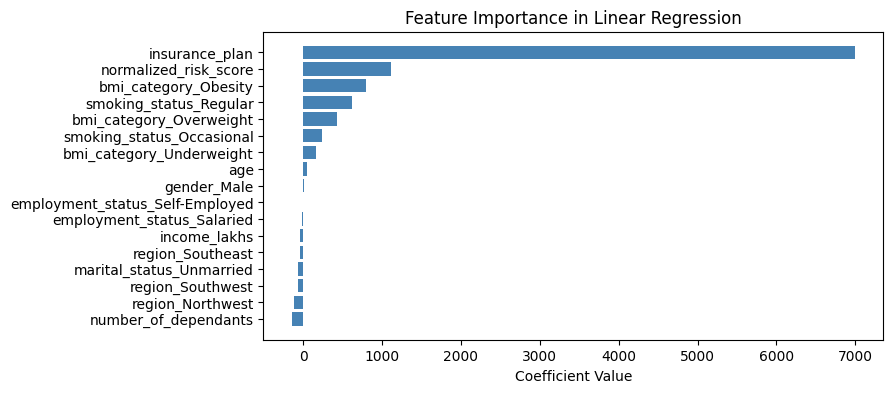

In [45]:
feature_importance = model_lr.coef_

# Create a DataFrame for easier handling
coef_df = pd.DataFrame(feature_importance, index=X_train.columns, columns=['Coefficients'])

# Sort the coefficients for better visualization
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

# Plotting
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Linear Regression')
plt.show()

### Ridge Regression

In [46]:
model_rg = Ridge(alpha=1)
model_rg.fit(X_train, y_train)
test_score = model_rg.score(X_test, y_test)
train_score = model_rg.score(X_train, y_train)
train_score, test_score

(0.6020466631305188, 0.6047715291063814)

In [47]:
y_pred = model_rg.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print("Ridge Regression ==> MSE: ", mse_lr, "RMSE: ", rmse_lr)

Ridge Regression ==> MSE:  3005573.963832464 RMSE:  1733.6591256162394


### Xgboost

In [48]:
model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)
test_score = model_xgb.score(X_test, y_test)
train_score = model_xgb.score(X_train, y_train)
train_score, test_score

(0.7251046895980835, 0.5638787746429443)

In [51]:
y_pred = model_xgb.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print("XGBoost Regression ==> MSE: ", mse_lr, "RMSE: ", rmse_lr)

XGBoost Regression ==> MSE:  3316549.0 RMSE:  1821.1394784584731


In [52]:
model_xgb = XGBRegressor()
param_grid = {
    'n_estimators': [20, 40, 50],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
}
random_search = RandomizedSearchCV(model_xgb, param_grid, n_iter=10, cv=3, scoring='r2', random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
random_search.best_score_

np.float64(0.5997088948885599)

In [53]:
random_search.best_params_

{'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1}

In [59]:
best_model = random_search.best_estimator_

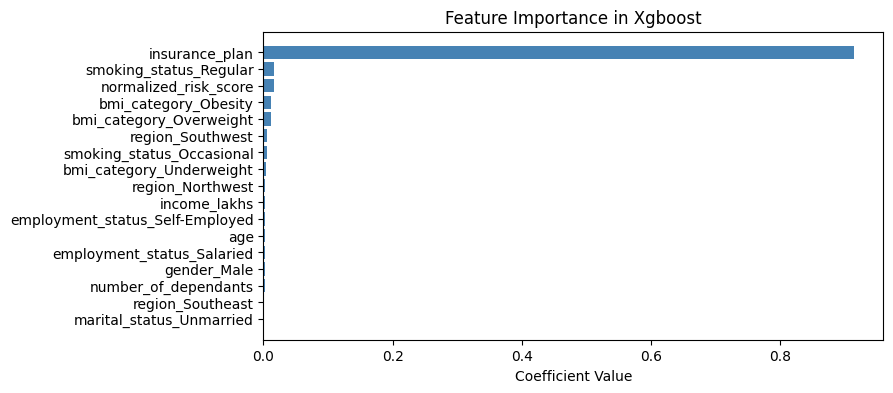

In [60]:
feature_importance = best_model.feature_importances_

# Create a DataFrame for easier handling
coef_df = pd.DataFrame(feature_importance, index=X_train.columns, columns=['Coefficients'])

# Sort the coefficients for better visualization
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

# Plotting
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Xgboost')
plt.show()

In [61]:
best_model = model_lr

### Error Analysis

In [62]:
y_pred = best_model.predict(X_test)
residuals = y_pred - y_test
resduals_pct = residuals / y_test*100

results_df = pd.DataFrame({
    'actual': y_test, 
    'predicted': y_pred, 
    'diff': residuals, 
    'diff_pct': resduals_pct
})
results_df.head()

,actual,predicted,diff,diff_pct
12774,6238,6625.420564,387.420564,6.210653
14758,9462,7117.148903,-2344.851097,-24.781770
13205,5152,7052.316369,1900.316369,36.885023
14278,6988,7924.504344,936.504344,13.401608
19351,4917,6696.274716,1779.274716,36.186185


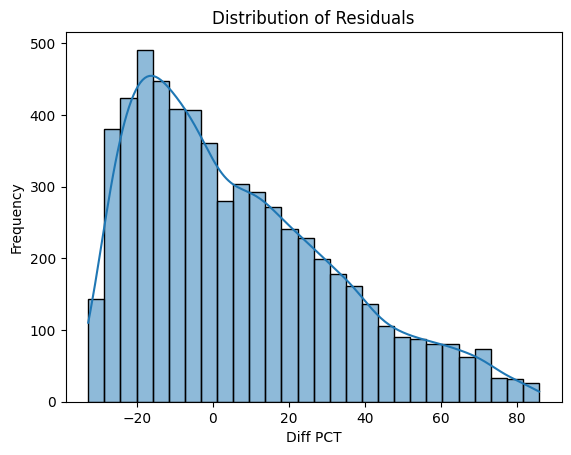

In [63]:
sns.histplot(results_df['diff_pct'], kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Diff PCT')
plt.ylabel('Frequency')
plt.show()

In [65]:
extreme_error_threshold = 10  # You can adjust this threshold based on your domain knowledge or requirements
extreme_results_df = results_df[np.abs(results_df['diff_pct']) > extreme_error_threshold]
extreme_results_df.shape

(4404, 4)

In [66]:
extreme_errors_pct = extreme_results_df.shape[0]*100/X_test.shape[0]
extreme_errors_pct

73.08330567540658

In [67]:
extreme_results_df[abs(extreme_results_df.diff_pct)>50].sort_values("diff_pct",ascending=False)

,actual,predicted,diff,diff_pct
10288,3623,6730.355627,3107.355627,85.767475
16580,3538,6566.644257,3028.644257,85.603286
3652,3536,6560.929382,3024.929382,85.546645
17084,3562,6608.314334,3046.314334,85.522581
18629,3616,6684.432249,3068.432249,84.857087
...,...,...,...,...
1597,4653,6988.954171,2335.954171,50.203184
12185,4440,6666.968404,2226.968404,50.156946
15966,4709,7070.742860,2361.742860,50.153809
4086,4592,6890.471576,2298.471576,50.053824


In [68]:
extreme_errors_df = X_test.loc[extreme_results_df.index]
extreme_errors_df.head(2)

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
14758,0.285714,0.000000,0.060606,0.0,0.0,0,0,0,1,1,0,0,0,0,1,0,1
13205,0.714286,0.333333,0.141414,0.0,0.0,1,1,0,0,1,0,0,0,0,1,0,1


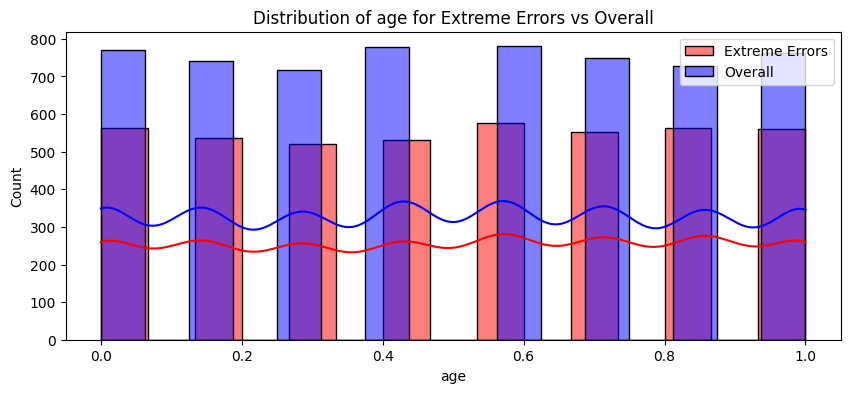

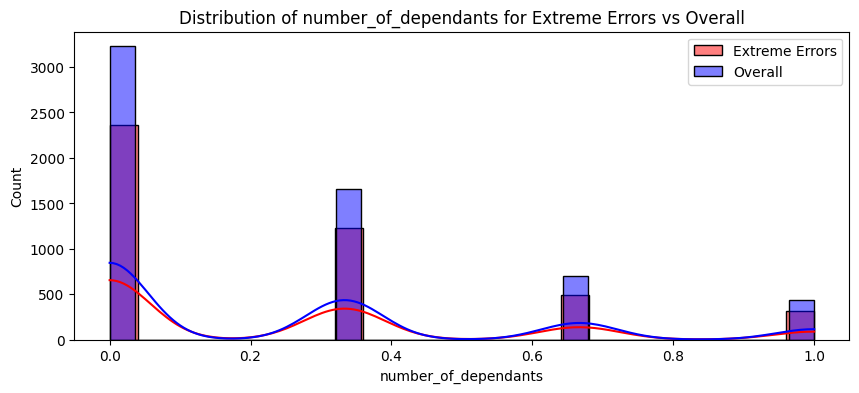

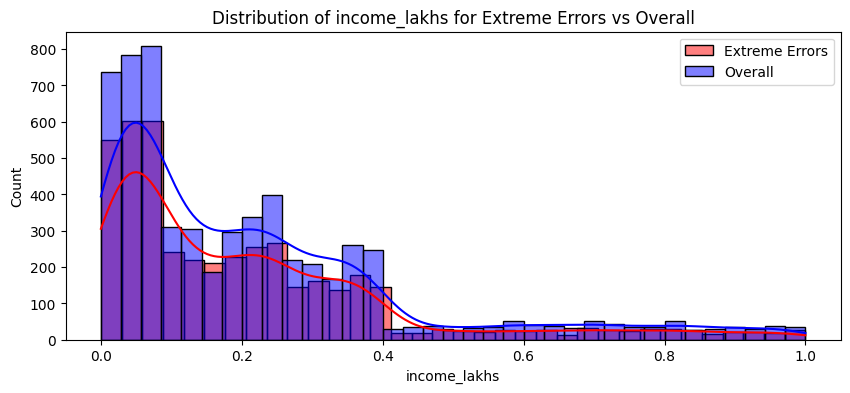

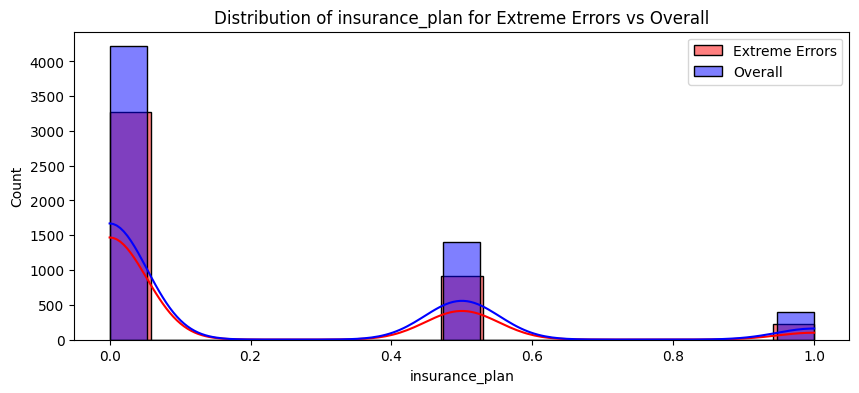

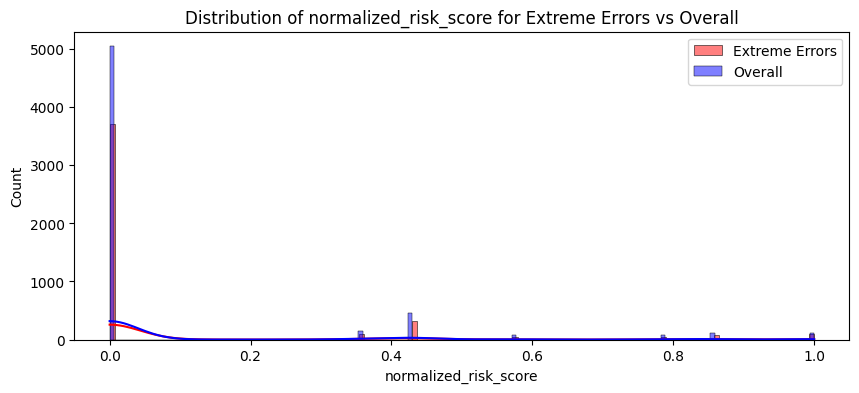

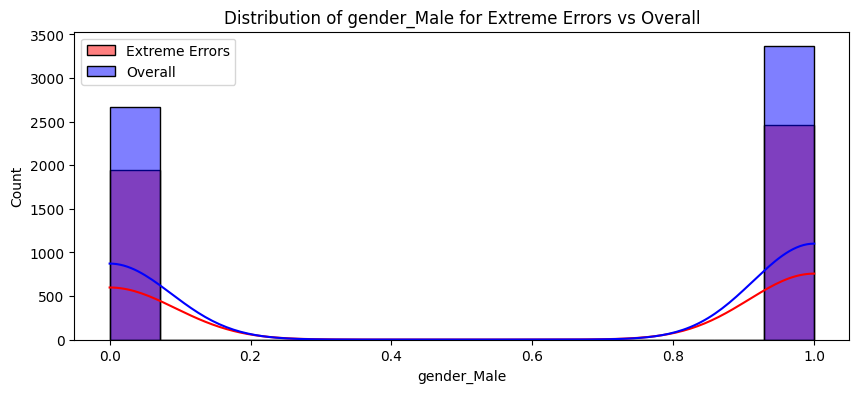

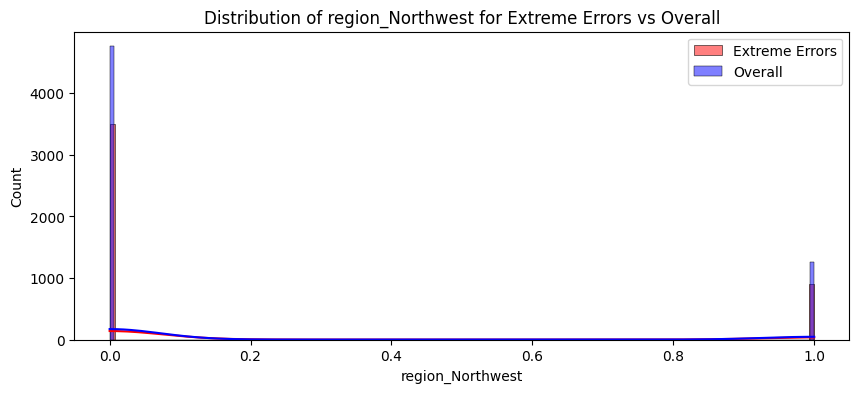

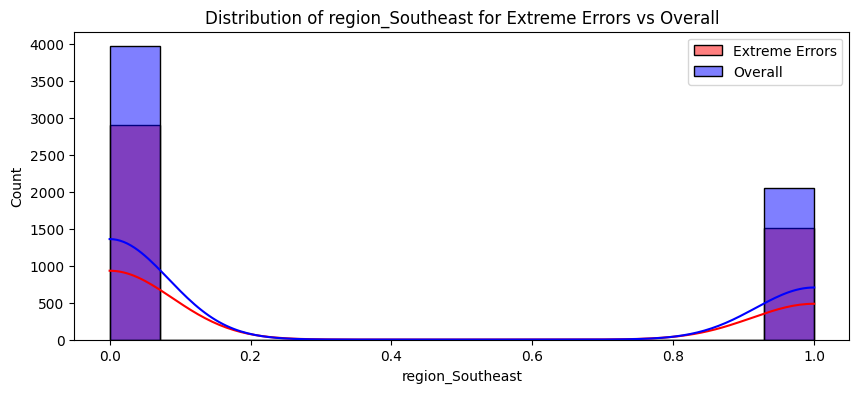

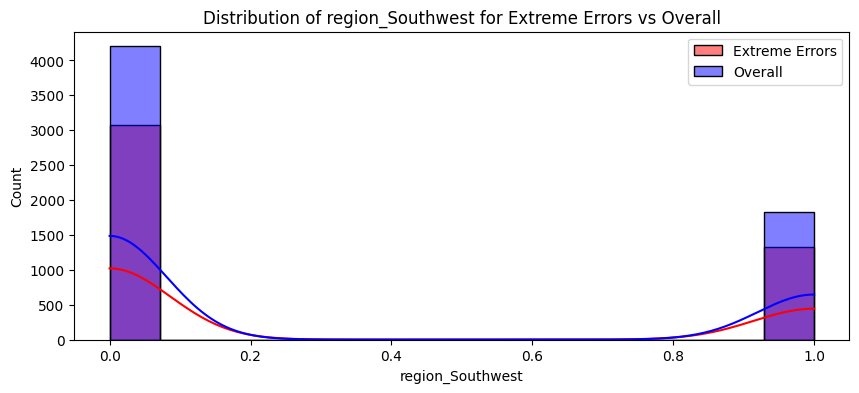

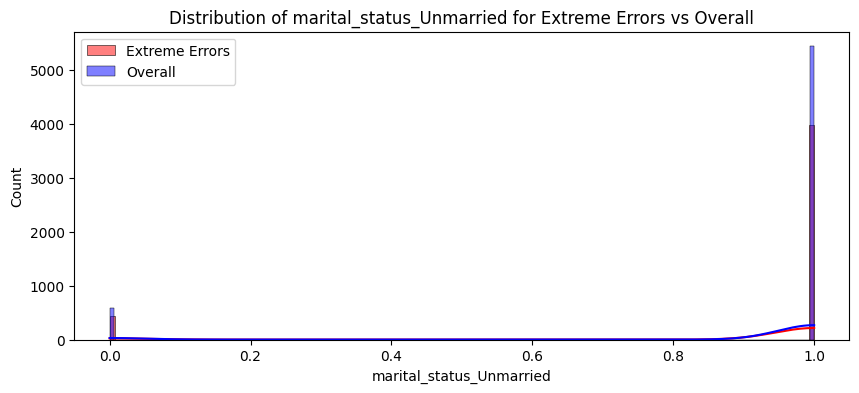

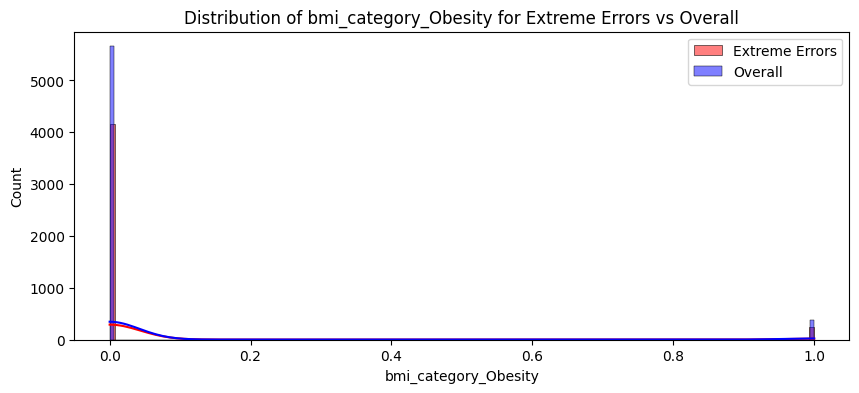

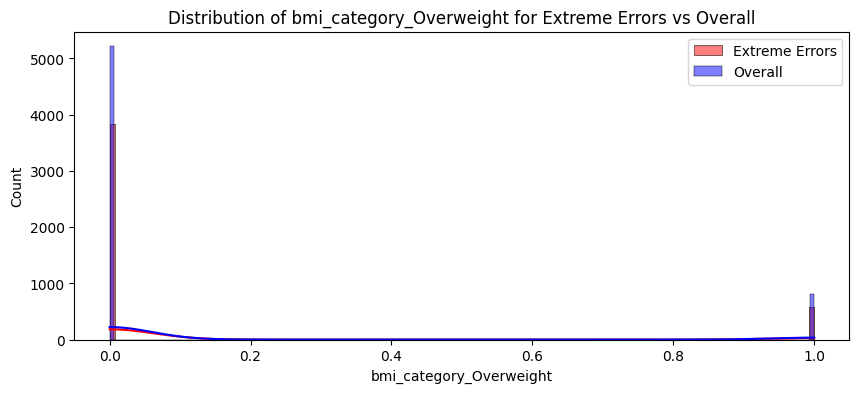

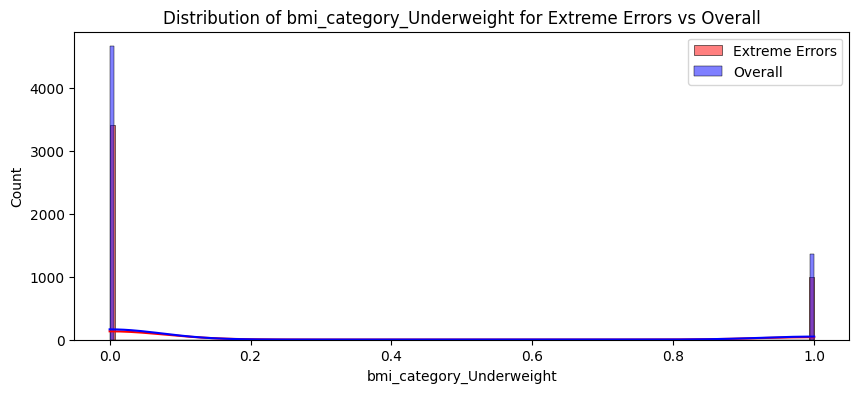

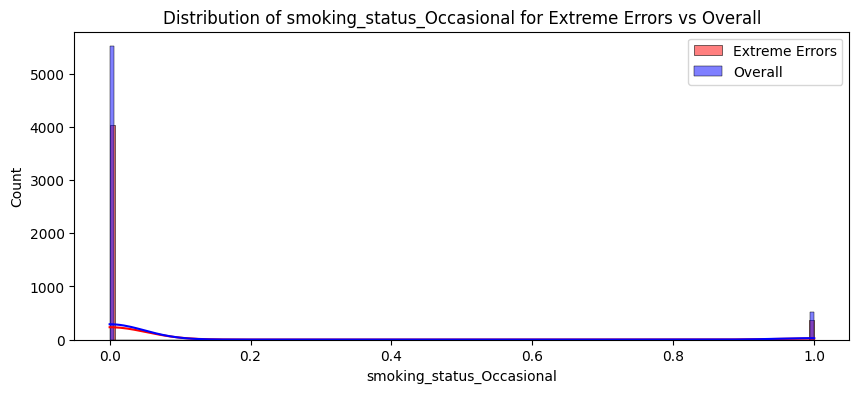

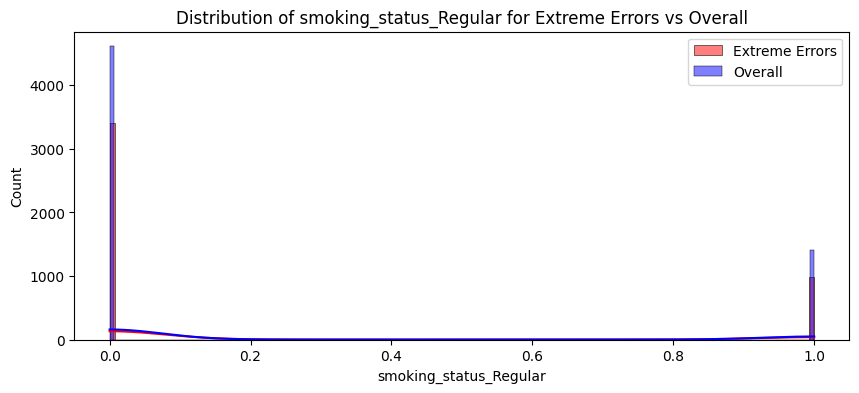

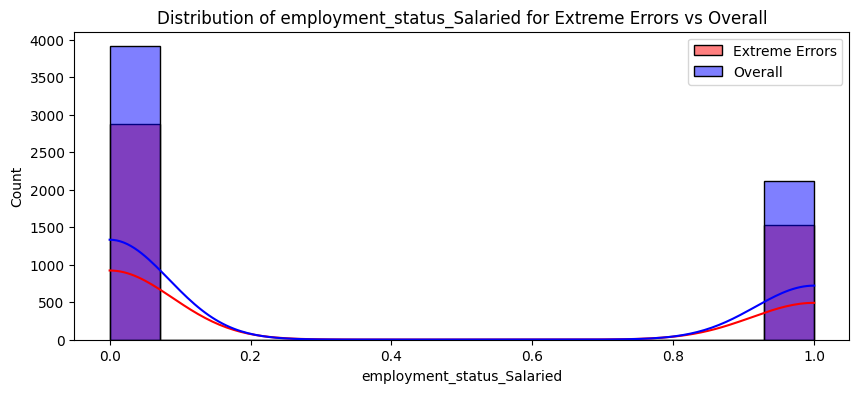

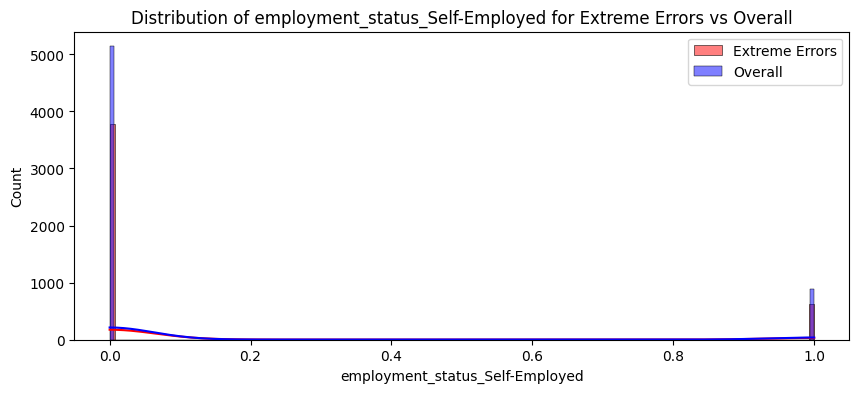

In [69]:
for feature in X_test.columns:
    plt.figure(figsize=(10, 4))
    sns.histplot(extreme_errors_df[feature], color='red', label='Extreme Errors', kde=True)
    sns.histplot(X_test[feature], color='blue', label='Overall', alpha=0.5, kde=True)
    plt.legend()
    plt.title(f'Distribution of {feature} for Extreme Errors vs Overall')
    plt.show()

### Reverse scaling

In [179]:
extreme_errors_df['income_level']=-1

In [180]:
df_reversed = pd.DataFrame()
df_reversed[cols_to_scale] = scaler.inverse_transform(extreme_errors_df[cols_to_scale])
df_reversed.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
0,23.0,1.0,-2.0,14.0,1.0
1,19.0,1.0,-2.0,4.0,1.0
2,18.0,1.0,-2.0,3.0,1.0
3,21.0,0.0,-2.0,25.0,1.0
4,24.0,1.0,-2.0,8.0,2.0


In [181]:
df_reversed.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan
count,4487.000000,4487.000000,4487.0,4487.000000,4487.000000
mean,21.804992,0.739247,-2.0,21.182527,1.302429
std,3.172355,0.968855,0.0,20.598596,0.563135
min,18.000000,0.000000,-2.0,1.000000,1.000000
25%,20.000000,0.000000,-2.0,6.000000,1.000000
50%,22.000000,0.000000,-2.0,15.000000,1.000000
75%,24.000000,1.000000,-2.0,30.000000,1.000000
max,60.000000,5.000000,-2.0,100.000000,3.000000


<Axes: xlabel='age', ylabel='Count'>

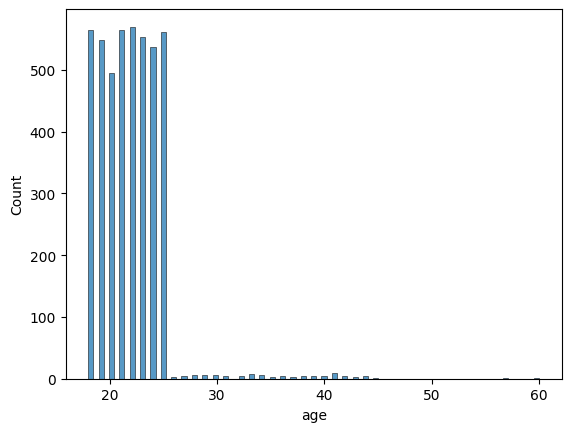

In [182]:
sns.histplot(df_reversed.age)

This shows that majority of the extreme errors are coming from young age group (i.e. <25 years of age). We need to may be build a separate model for this segment